### Quelle der Daten: 
https://www.bundestag.de/services/opendata

### Erläuterungen
WP steht für Wahlperiode

In [6]:
import sys
sys.path.append("../src")

In [7]:
import os
import re
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from config import CURRENT_YEAR, MDB_XML_PATH, DF_MDB_PATH, DF_MDB_WP_PATH, DF_MDB_WP_STARTDATEN_PATH, PLOT_PATH, list_of_parteien, religion_mapping, family_status_mapping, klassifiziere_beruf
from berufe_mapping import basic_cleaning_berufe
from parse_data import get_mdb_data, get_mdb_wp_data

In [8]:
sns.set_theme()

# parse xml data into dataFrame / .csv fomat

In [9]:
df_mdb = get_mdb_data(MDB_XML_PATH)
print(df_mdb.shape)
df_mdb.head()

(4089, 34)


,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,2,12,13,14,15,16,1,17,18,19
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [10]:
df_mdb_wp = get_mdb_wp_data(df_mdb)

In [11]:
# deleteme
df_mdb_wp[df_mdb_wp.BERUF.str.contains('jurist', na=False)][['NACHNAME', 'VORNAME']]

,NACHNAME,VORNAME
573,Freiwald,Friedrich Wilhelm
1895,Rutschke,Wolfgang
2121,Schwörer,Hermann
4662,Freiwald,Friedrich Wilhelm
5374,Lauritzen,Lauritz
...,...,...
77577,Müller,Axel
77607,Reusch,Roman Johannes
77618,Schmid,Nils
77632,Seitz,Thomas


# compute Age

In [12]:
df_mdb['GEBURSDATUM_DATE'] = pd.to_datetime(df_mdb.GEBURTSDATUM, format='%d/%m/%Y', errors='coerce')

In [13]:
df_mdb.head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,12,13,14,15,16,1,17,18,19,GEBURSDATUM_DATE
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaT


## Insight: es werden immer mehr Abgeordnete

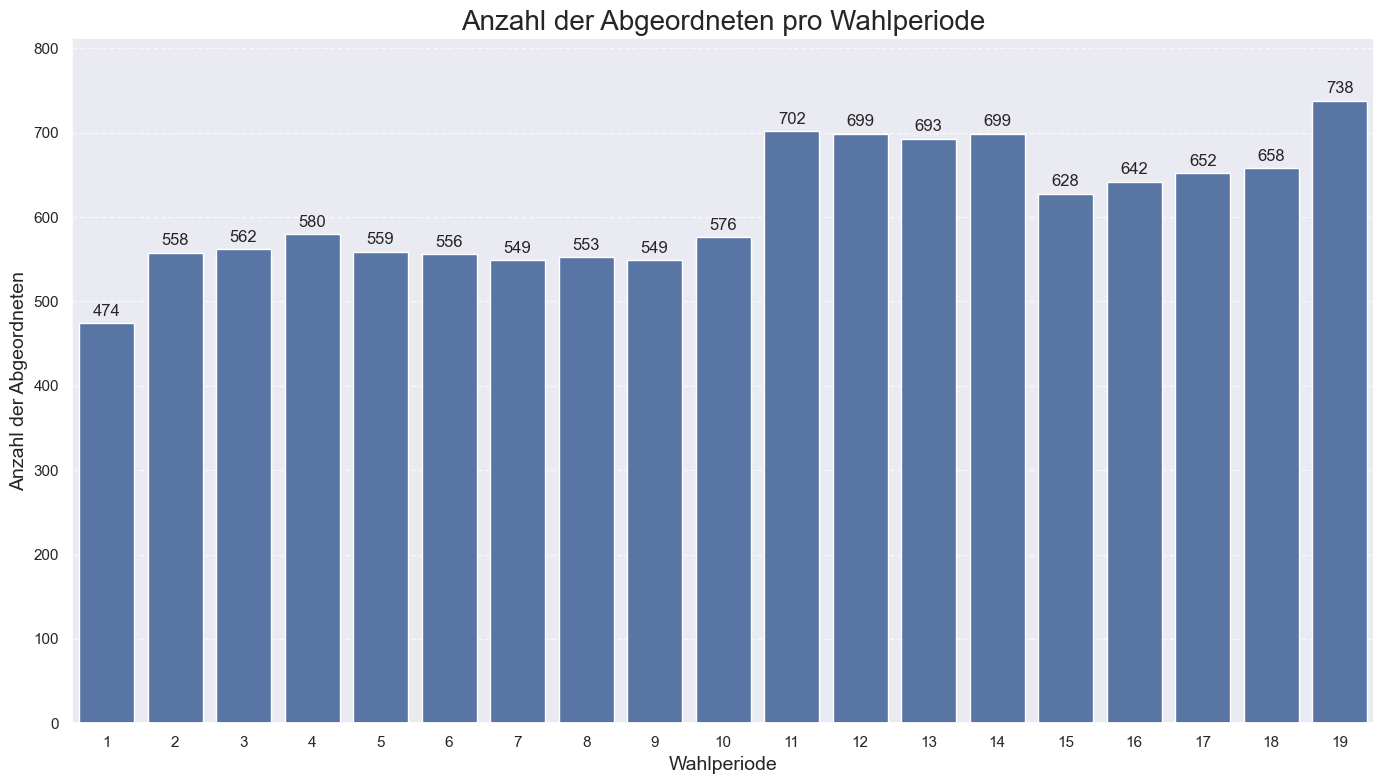

In [14]:
# Daten vorbereiten
wps = [column for column in df_mdb.columns if isinstance(column, int)]
abgeordnete_pro_wp = df_mdb[wps].sum().sort_index()

# Plot erstellen
fig, ax = plt.subplots(figsize=(14, 8))

# Balkendiagramm
sns.barplot(x=abgeordnete_pro_wp.index, y=abgeordnete_pro_wp.values, ax=ax)

# Beschriftungen hinzufügen
ax.set_title('Anzahl der Abgeordneten pro Wahlperiode', fontsize=20)
ax.set_xlabel('Wahlperiode', fontsize=14)
ax.set_ylabel('Anzahl der Abgeordneten', fontsize=14)

# Werte über den Balken anzeigen (als ganze Zahlen)
for i, v in enumerate(abgeordnete_pro_wp.values):
    ax.text(i, v + 5, f'{int(v)}', ha='center', va='bottom')

# Y-Achse bei 0 beginnen lassen und bis zum maximalen Wert plus etwas Abstand gehen
y_max = max(abgeordnete_pro_wp.values)
ax.set_ylim(0, y_max * 1.1)  # 10% Abstand nach oben für die Beschriftungen

# Grid für bessere Lesbarkeit
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Layout optimieren
plt.tight_layout()

# SVG
plt.savefig(PLOT_PATH / 'anzahl_abgeordneter.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
df_mdb[wps].sum().sort_index().tail()

15    628.0
16    642.0
17    652.0
18    658.0
19    738.0
dtype: float64

In [16]:
# total number of abgeordnete (counting multiple wps as multiple entries)
df_mdb[wps].sum().sum()

11627.0

# look at one VITA KURZ

In [17]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(df_mdb_wp[df_mdb_wp.NACHNAME =='Baerbock'].iloc[0].VITA_KURZ)

('2000/04 Studium der Politikwissenschaft und Öffentliches Recht in Hamburg; '
 '2000/03 freie Mitarbeit bei der Hannoverschen Allgemeinen Zeitung; 2005 '
 'Master im Völkerrecht (LL.M.) an der LSE London; 2005/08 Büroleiterin der '
 'Europaabgeordneten Elisabeth Schroedter in Brüssel und Potsdam. 2008/09 '
 'Referentin für Außen- und Sicherheitspolitik bei der Grünen '
 'Bundestagsfraktion. 2009/13 Landesvors. BÜNDNIS 90/DIE GRÜNEN Brandenburg. '
 'Seit 2005 Mitgl. von Bündnis 90/Die Grünen, 2009/12 Mitgl. im Vorstand der '
 'Europäischen Grünen Partei; 2012/15 Mitgl. im Parteirat von Bündnis 90/Die '
 'Grünen, seit Jan. 2018 Bundesvors. von Bündnis90/Die Grünen. Englisch (f), '
 'Französisch (G), Spanisch (G). - MdB seit Okt. 2013.')


In [18]:
# TODO: Vita kurz mit LLM klassifizieren

# clean data 1. missing values

In [19]:
dimensions_replace_na = ['NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT', 'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION', 'BERUF', 'PARTEI_KURZ']
df_mdb[dimensions_replace_na].isna().sum()

NACHNAME            0
VORNAME             0
GEBURTSDATUM        0
GEBURTSORT          4
GEBURTSLAND      4010
STERBEDATUM      2199
GESCHLECHT          0
FAMILIENSTAND      81
RELIGION          227
BERUF               3
PARTEI_KURZ         3
dtype: int64

In [20]:
df_mdb[dimensions_replace_na] = df_mdb[dimensions_replace_na].fillna('UNBEKANNT')

# 2. replace values: PARTEI_KURZ

In [21]:
df_mdb.PARTEI_KURZ.value_counts()[:12]

CDU                      1347
SPD                      1329
FDP                       460
CSU                       269
BÜNDNIS 90/DIE GRÜNEN     180
DIE LINKE.                128
AfD                        88
PDS                        54
GRÜNE                      51
DIE GRÜNEN/BÜNDNIS 90      28
DP                         27
FU                         21
Name: PARTEI_KURZ, dtype: int64

In [22]:
# some cleaning necessary: 'BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90' => 'GRÜNE'
for grünen_alias in ['BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90', 'GRÜNE']:
    df_mdb.replace(grünen_alias, 'DIE GRÜNEN', inplace=True)

# replace values: RELIGION

In [23]:
df_mdb['RELIGION_MAPPED'] = df_mdb['RELIGION'].map(religion_mapping)

In [24]:
df_mdb['RELIGION'].value_counts()

ohne Angaben                 1214
evangelisch                  1154
katholisch                    870
römisch-katholisch            316
UNBEKANNT                     227
evangelisch-lutherisch        138
konfessionslos                118
evangelisch-reformiert         15
religionslos                    7
Atheistin                       6
muslimisch                      5
evangelisch-freikirchlich       3
freireligiös                    3
Islam                           3
Atheist                         2
neuapostolisch                  1
protestantisch                  1
humanistisch                    1
griechisch-orthodox             1
alevitisch                      1
alt-katholisch                  1
orthodox                        1
russisch-orthodox               1
Name: RELIGION, dtype: int64

In [25]:
df_mdb['RELIGION_MAPPED'].value_counts()

unbekannt         1441
evangelisch       1311
katholisch        1187
konfessionslos     133
muslimisch           9
sonstige             5
orthodox             3
Name: RELIGION_MAPPED, dtype: int64

<Axes: >

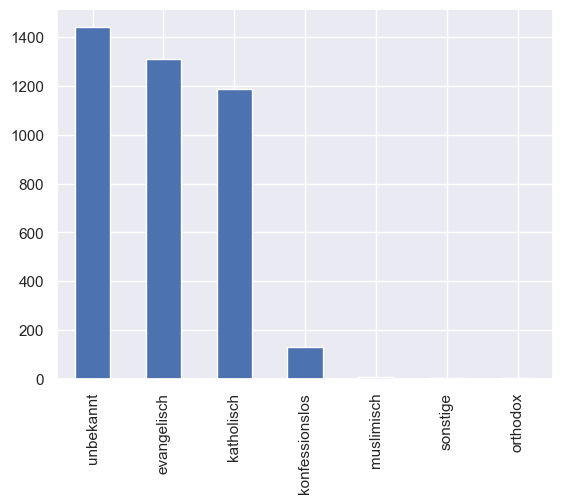

In [26]:
# erkenntnis: nur christen und einige wenige konfessionslose
df_mdb['RELIGION_MAPPED'].value_counts().plot(kind='bar')

# replace values: FAMILIENSTAND

In [27]:
df_mdb['FAMILIENSTAND'].value_counts().head(4)

verheiratet, 2 Kinder    932
verheiratet              565
verheiratet, 3 Kinder    550
keine Angaben            540
Name: FAMILIENSTAND, dtype: int64

<Axes: xlabel='FAMILIENSTAND_MAPPED'>

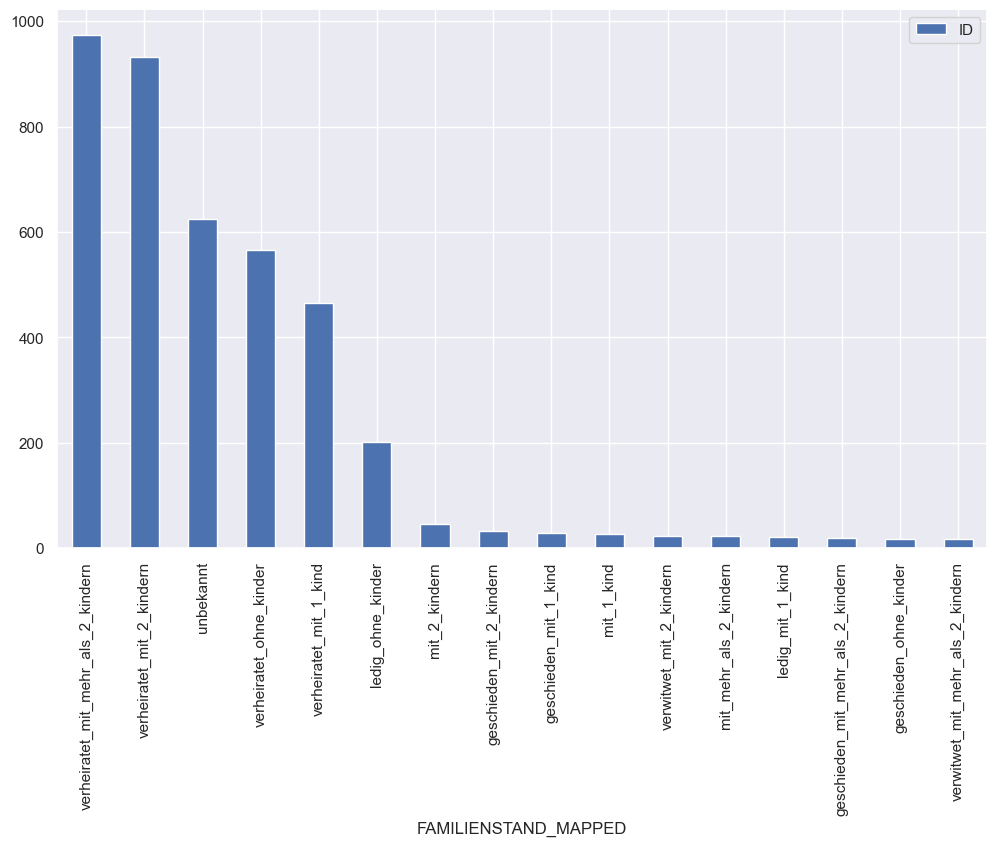

In [28]:
# gehen sie weiter. hier gibt es kein Klischee zu erkennen!
df_mdb['FAMILIENSTAND_MAPPED'] = df_mdb['FAMILIENSTAND'].map(family_status_mapping)

df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16).plot(kind='bar', figsize=(12,7))

In [29]:
df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND_MAPPED,
verheiratet_mit_mehr_als_2_kindern,974
verheiratet_mit_2_kindern,932
unbekannt,624
verheiratet_ohne_kinder,565
verheiratet_mit_1_kind,466
ledig_ohne_kinder,202
mit_2_kindern,45
geschieden_mit_2_kindern,32
geschieden_mit_1_kind,28


# replace values: BERUFE

In [30]:
# number of different jobs: 2k
len(set(df_mdb.BERUF))

2201

In [31]:
df_mdb['BERUF_MAPPED'] = df_mdb['BERUF'].copy()

In [32]:
df_mdb[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head()

,ID
BERUF,
Rechtsanwalt,182
Geschäftsführer,80
Landwirt,79
Angestellter,63
Rechtsanwalt und Notar,47


In [35]:
'''very basic cleaning: lowercasing, removing dipl., (fh) and a.d.'''
df_mdb = basic_cleaning_berufe(df_mdb , column = 'BERUF_MAPPED')

In [36]:
df_mdb['BERUF_MAPPED'] = df_mdb['BERUF'].apply(klassifiziere_beruf)

In [37]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF_MAPPED,
Sonstige,756
Jurist*in,549
Lehrer*in,461
Berufspolitiker*in,355
Land-/Forstwirt*in,259
Kaufmann/-frau,237
Unternehmer*in,233
Ingenieur*in,223


# construct df_mdb_wp

In [38]:
df_mdb_wp = get_mdb_wp_data(df_mdb)
print(df_mdb_wp.shape)

(11627, 20)


In [39]:
df_mdb_wp[df_mdb_wp.NACHNAME == 'Merkel'].head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP
42355,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,NaT,evangelisch,verheiratet_ohne_kinder,Berufspolitiker*in,12
46444,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,NaT,evangelisch,verheiratet_ohne_kinder,Berufspolitiker*in,13
50533,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,NaT,evangelisch,verheiratet_ohne_kinder,Berufspolitiker*in,14
54622,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,NaT,evangelisch,verheiratet_ohne_kinder,Berufspolitiker*in,15
56261,11003591,Merkel,Petra,18.09.1947,Berlin,UNBEKANNT,UNBEKANNT,weiblich,"geschieden, 1 Kind",evangelisch,Kaufmännische Angestellte,SPD,None,None,3,NaT,evangelisch,geschieden_mit_1_kind,Kaufmann/-frau,15


# compute age

In [40]:
df_wp_startdaten = pd.read_csv(DF_MDB_WP_STARTDATEN_PATH, index_col=0)
df_wp_startdaten

,START_DATE
1,1949-09-07
2,1953-10-06
3,1957-10-15
4,1961-10-17
5,1965-10-19
6,1969-10-20
7,1972-12-13
8,1976-12-14
9,1980-11-04
10,1983-03-29


In [41]:
df_wp_startdaten['START_DATE'] = pd.to_datetime(df_wp_startdaten['START_DATE'])

In [42]:
df_mdb_wp = df_mdb_wp.join(df_wp_startdaten, on='WP')

In [43]:
df_mdb_wp['START_DATE'] = pd.to_datetime(df_mdb_wp['START_DATE'])
df_mdb_wp['GEBURTSDATUM'] = pd.to_datetime(df_mdb_wp['GEBURTSDATUM'])

/var/folders/s9/hrwvzf4j77g5lgp9_8n3z3s00000gn/T/ipykernel_67912/845667782.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_mdb_wp['GEBURTSDATUM'] = pd.to_datetime(df_mdb_wp['GEBURTSDATUM'])


In [ ]:
def match_age(x):
    if x < 30:
        return ('< 30')
    elif x < 40:
        return('30 - 40')
    elif x < 50:
        return('40 - 50')
    elif x < 60:
        return('50 - 60')
    elif x < 70:
        return('70 - 80')
    else:
        return('>= 80')

In [ ]:
match_age(80)

In [ ]:
df_mdb_wp['START_AGE_IN_YEARS'] = df_mdb_wp['START_DATE'] - df_mdb_wp['GEBURTSDATUM']
df_mdb_wp['START_AGE_IN_YEARS'] = df_mdb_wp['START_AGE_IN_YEARS']/np.timedelta64(1,'Y')

df_mdb_wp

In [ ]:
df_mdb_wp['START_AGE_IN_YEARS'].hist(bins=32)

In [ ]:
#df_mdb_wp['START_AGE_IN_YEARS'].plot(kind='bar')
df_mdb_wp['START_AGE_IN_YEARS'][:4]

In [ ]:
df_mdb_wp['START_AGE_IN_YEARS_MAPPED'] = df_mdb_wp['START_AGE_IN_YEARS'].apply(lambda x: match_age(x)) 
df_mdb_wp['START_AGE_IN_YEARS_MAPPED'].hist()

In [ ]:
list_of_altersklassen = sorted(list(set(df_mdb_wp['START_AGE_IN_YEARS_MAPPED'])))
list_of_altersklassen = ['< 30', '30 - 40', '40 - 50', '50 - 60', '70 - 80',  '>= 80']
list_of_altersklassen

# Jahre im Amt

In [ ]:
df_mdb_wp = df_mdb_wp.join(df_mdb_wp[['ID', 'START_DATE']].groupby('ID').min(), how='left', rsuffix='_FIRST', on='ID')

In [ ]:
df_mdb_wp['NUM_YEARS_IN_BT'] = df_mdb_wp['START_DATE'] - df_mdb_wp['START_DATE_FIRST']
df_mdb_wp['NUM_YEARS_IN_BT'] = df_mdb_wp['NUM_YEARS_IN_BT']/np.timedelta64(1,'Y')

In [ ]:
df_mdb_wp.shape

In [ ]:
df_mdb_wp.columns

In [ ]:
# delemte
selected_df = df_mdb_wp[(df_mdb_wp['WP']>= 1) & (df_mdb_wp['WP']<= 19)]
#selected_df = selected_df[selected_df['PARTEI_KURZ'].isin(selected_parteien)]
grouped = selected_df[['ID', 'START_DATE', 'NUM_YEARS_IN_BT', 'PARTEI_KURZ']].groupby(['START_DATE', 'PARTEI_KURZ']).mean()

In [ ]:
grouped.reset_index(inplace=True)

In [ ]:
# delemte
grouped[grouped['PARTEI_KURZ']=='CDU']['NUM_YEARS_IN_BT'].plot()

In [ ]:
# deleteme 
grouped[grouped['START_DATE']=='2017-10-24']
# START_DATE

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

selected_parties=['SPD', 'CDU', 'FDP', 'CSU']
selected_df = df_mdb_wp[(df_mdb_wp['WP']>= 1) & (df_mdb_wp['WP']<= 19)]
selected_df = selected_df[selected_df['PARTEI_KURZ'].isin(selected_parties)]
grouped = selected_df[['ID', 'START_DATE', 'NUM_YEARS_IN_BT', 'PARTEI_KURZ']].groupby(['START_DATE', 'PARTEI_KURZ']).mean()
#grouped.reset_index(inplace=True)
grouped.head()

In [ ]:
#new_index = pd.MultiIndex.from_product([selected_parties, sorted(set(grouped.reset_index()['WP']))], names=['PARTEI_KURZ', 'WP'])
new_index = pd.MultiIndex.from_product([grouped.index.levels[0], grouped.index.levels[1]], names=['START_DATE', 'PARTEI_KURZ'])
new_index#

In [ ]:
    # create entries also for 0 values
grouped_reindexed = grouped.reindex(new_index, fill_value=0)
grouped_reindexed.head(12)

In [ ]:
# double deleteme
df_mdb_wp.sort_values(by='NUM_YEARS_IN_BT')[['NACHNAME', 'VORNAME', 'PARTEI_KURZ', 'WP', 'NUM_YEARS_IN_BT']].tail()

In [ ]:
df_mdb_wp[df_mdb_wp.PARTEI_KURZ=='FDP'].sort_values(by='NUM_YEARS_IN_BT')[['NACHNAME', 'VORNAME', 'PARTEI_KURZ', 'WP', 'NUM_YEARS_IN_BT']].tail()

In [ ]:
grouped_reindexed.reset_index(inplace=True)

In [ ]:
# make it orderable
grouped_reindexed['PARTEI_KURZ'] = pd.Categorical(grouped_reindexed['PARTEI_KURZ'], selected_parties)

In [ ]:
grouped_reindexed.sort_values(by=['START_DATE', 'PARTEI_KURZ'], inplace=True)

In [ ]:
#fig = px.scatter(x=grouped['NUM_YEARS_IN_BT'].index, y= grouped['NUM_YEARS_IN_BT'])
fig = go.Figure(data=px.line(grouped_reindexed, x='START_DATE', y= 'NUM_YEARS_IN_BT', 
                                color='PARTEI_KURZ', color_discrete_sequence = LIST_OF_COLORS))
fig.update_layout(title='Bleibedauer der Abgeordneten im Bundestag',
               xaxis_title='',
               yaxis_title='Jahre im BT bei Beginn der WP')
fig.show()

In [ ]:
# end deleteme

# save as csv

In [ ]:
df_mdb.to_csv(DF_MDB_PATH, index=None)
df_mdb_wp.to_csv(DF_MDB_WP_PATH, index=None)

# read in data. exploratory data analysis

In [ ]:
df_mdb = pd.read_csv(DF_MDB_PATH, index_col=None)
df_mdb_wp = pd.read_csv(DF_MDB_WP_PATH, index_col=None)

In [ ]:
df_mdb.columns

In [ ]:
df_mdb.tail()

In [ ]:
df_mdb_wp[['ID', 'WP']].groupby('WP').count().sort_values(by='WP', ascending=False).head()

# quality checks

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==19) & (df_mdb_wp.PARTEI_KURZ == 'CDU')]

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==18) & (df_mdb_wp.PARTEI_KURZ == 'CDU') & (df_mdb_wp.BERUF.str.contains('Bürgermeister'))]